In [1]:
import math
import torch

In [2]:
torch.set_grad_enabled(False)

In [3]:
# This will be our main class from which a lot of other classes will inherit (e.g. fully connected layer)
class Module(object):
    def __init__(self):
        self.output = None
        self.grad_input = None
    
    def forward(self, inpt):
        return self.update_output(inpt)

    def backward(self, inpt, grad_output):
        self.update_grad_input(inpt, grad_output)
        self.acc_grad_params(inpt, grad_output)
        return self.grad_input
    
    def update_output(self, inpt):        
        pass

    # gradient with respect to input
    def update_grad_input(self, inpt, grad_output):       
        pass   
    
    # gradient with respect to parameters
    def acc_grad_params(self, inpt, grad_output):
        pass
    
    def zero_grad_params(self): 
        pass
        
    def get_params(self):
        return []
        
    def get_grad_params(self):
        return []
    
    def __repr__(self):
        return "Module"

In [4]:
# this is a container class like keras's Sequential model
class Sequential(Module):    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.y = []
   
    def add(self, module):
        self.modules.append(module)

    def update_output(self, inpt): 
        self.y = [] 

        y_p = self.modules[0].forward(inpt)
        self.y.append(y_p)
        for i in range(1,len(self.modules)):
            y_n = self.modules[i].forward(y_p)
            self.y.append(y_n)
            y_p = y_n
        
        self.output = y_n
            
        return self.output

    def backward(self, inpt, grad_output): 
        n = len(self.modules)
        g_n = self.modules[n-1].backward(self.y[n-2],grad_output)
        for i in range(n-2,0,-1):
            g_p = self.modules[i].backward(self.y[i-1],g_n)
            g_n = g_p
            
        self.grad_input = self.modules[0].backward(inpt,g_p)
        return self.grad_input

    def zero_grad_params(self): 
        for module in self.modules:
            module.zero_grad_params()
    
    def get_params(self):
        return [x.get_params() for x in self.modules]
    
    def get_grad_params(self):
        return [x.get_grad_params() for x in self.modules]
    
    def __repr__(self):
        return "".join([str(each) + '\n' for each in self.modules])
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)

In [5]:
# input: batch_size x n_features1
# output: batch_size x n_features2

class DenseLayer(Module):
    def __init__(self, n_in, n_out):
        super(DenseLayer, self).__init__()
       
        #initializing weights 
        stdv = 1./math.sqrt(n_in)
        self.W = torch.FloatTensor(n_out,n_in).uniform_(-stdv,stdv)
        self.b = torch.FloatTensor(n_out).uniform_(-stdv,stdv)
        
        self.gradW = torch.zeros_like(self.W)
        self.gradb = torch.zeros_like(self.b)
    
    def update_output(self, inpt):
        self.output = torch.mm(inpt,self.W.T) + self.b  
        return self.output

    def update_grad_input(self, inpt, grad_output):
        self.grad_input = torch.mm(grad_output,self.W)
        return self.grad_input
    
    def acc_grad_params(self, inpt, grad_output):
        self.gradW = torch.mm(grad_output,input)
        self.gradb = grad_output.sum(axis=0) 
    
    def zero_grad_params(self):
        self.gradW = torch.zeros_like(self.gradW)
        self.gradb = torch.zeros_like(self.gradb)
        
    def get_params(self):
        return [self.W, self.b]
    
    def get_grad_params(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        return 'Linear %d -> %d' %(s[1],s[0])

In [6]:
d_layer = DenseLayer(2, 30)

In [7]:
d_layer.get_grad_params()

[tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.])]

In [8]:
d_layer.get_params()

[tensor([[-0.1072,  0.2325],
         [-0.0819,  0.6223],
         [-0.3322,  0.3836],
         [ 0.6053,  0.3187],
         [ 0.4630, -0.3651],
         [ 0.2603,  0.5011],
         [ 0.5215, -0.4900],
         [-0.0762, -0.5511],
         [ 0.6902, -0.6396],
         [-0.6313,  0.2492],
         [ 0.2465, -0.1852],
         [-0.6975, -0.3085],
         [-0.2476, -0.4278],
         [ 0.6618, -0.1658],
         [-0.5877, -0.1049],
         [-0.6501,  0.5329],
         [-0.6030,  0.0632],
         [ 0.1816, -0.2870],
         [ 0.4055,  0.4307],
         [ 0.4976, -0.4121],
         [-0.3169, -0.4019],
         [-0.6966,  0.5633],
         [-0.6931, -0.3022],
         [ 0.0359, -0.0270],
         [ 0.6333, -0.2177],
         [ 0.4782,  0.1215],
         [-0.2029,  0.1271],
         [-0.3590,  0.5745],
         [ 0.2156, -0.3936],
         [ 0.2028,  0.3490]]),
 tensor([-0.4624, -0.0098,  0.3034, -0.6513,  0.1048,  0.4211,  0.0675,  0.0607,
          0.0151,  0.5116,  0.5872, -0.2377,  0

---------------------------------------------------------------------------------------------------------------------

In [9]:
class Tanh(Module):
    def __init__(self):
         super(Tanh, self).__init__()
    
    def update_output(self, inpt):
        self.output = 2/(1+torch.exp(-2*inpt)) - 1
        return self.output
    
    def update_grad_input(self, inpt, grad_output):
        self.grad_input = (1 - self.output**2)*grad_output
        return self.grad_input

    def __repr__(self):
        return "Tanh"

In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def update_output(self, inpt):
        self.output = torch.max(inpt,torch.zeros_like(inpt))
        return self.output
    
    def update_grad_input(self, inpt, gradOutput):
        inpt[inpt<=0] = 0
        inpt[inpt>0] = 1
        self.gradInput = gradOutput * inpt
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [11]:
BB = torch.tensor([[1.,5.,6.],[-5.,3.,10.],[-1.,-1.,-10.],[2.,2.,4.]])
BB

tensor([[  1.,   5.,   6.],
        [ -5.,   3.,  10.],
        [ -1.,  -1., -10.],
        [  2.,   2.,   4.]])

In [12]:
torch.tanh(BB)

tensor([[ 0.7616,  0.9999,  1.0000],
        [-0.9999,  0.9951,  1.0000],
        [-0.7616, -0.7616, -1.0000],
        [ 0.9640,  0.9640,  0.9993]])

In [13]:
my_tanh = Tanh()

my_tanh.update_output(BB)

tensor([[ 0.7616,  0.9999,  1.0000],
        [-0.9999,  0.9951,  1.0000],
        [-0.7616, -0.7616, -1.0000],
        [ 0.9640,  0.9640,  0.9993]])

---------------------------------------------------------------------------------------------------------------------

In [14]:
class Loss(object):
    def __init__ (self):
        self.output = None
        self.grad_input = None
    
    def forward(self, inpt, target):
        return self.update_output(inpt, target)

    def backward(self, inpt, target):
        return self.update_grad_input(inpt, target)
    
    def update_output(self, inpt, target):
        return self.output

    def update_grad_input(self, inpt, target):
        return self.grad_input  

    def __repr__(self):
        return "Loss"

In [15]:
class MSE(Loss):
    def __init__(self):
        super(MSE, self).__init__()

    def update_output(self, inpt, target):   
        self.output = torch.sum((target - inpt)**2)/inpt.shape[0]
        return self.output 
 
    def update_grad_input(self, inpt, target):
        self.grad_input = -2*(target-inpt)/inpt.shape[0]
        return self.grad_input

    def __repr__(self):
        return "MSE"

In [16]:
BB

tensor([[  1.,   5.,   6.],
        [ -5.,   3.,  10.],
        [ -1.,  -1., -10.],
        [  2.,   2.,   4.]])

In [17]:
trg = torch.tensor([[  2.,   5.,   6.],
        [ -8.,   4.,  11.],
        [ -2.,  -1., -10.],
        [  0.,   0.,   5.]])

In [18]:
mse = MSE()

mse.update_output(BB,trg)

tensor(5.5000)

---------------------------------------------------------------------------------------------------------------------

In [19]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [20]:
train_size = 1000
test_size = 1000

X_train = torch.empty(train_size, 2).uniform_(0, 1)
X_test = torch.empty(train_size, 2).uniform_(0, 1)

X = torch.cat((X_train,X_test))

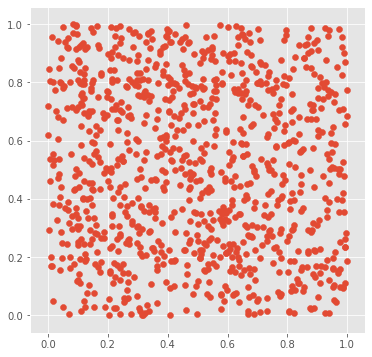

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0],X_train[:,1])
plt.show()

In [22]:
Y = torch.zeros(train_size+test_size)

In [23]:
for index,each in enumerate(X):
    if (each[0] - 0.5)**2 + (each[1] - 0.5)**2 <= 1/(2*math.pi):
        Y[index] = 1

In [24]:
Y_train = Y[:1000]
Y_test = Y[1000:]

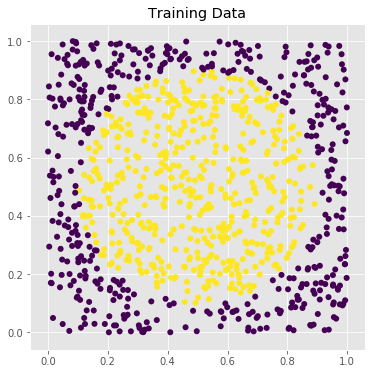

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train, edgecolors='none')
plt.title('Training Data')
plt.show()

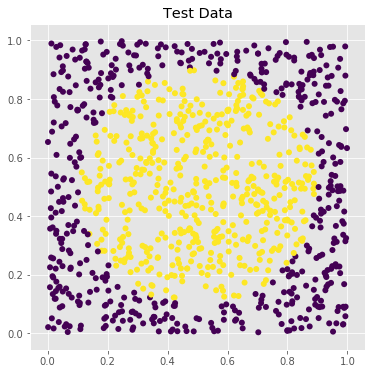

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0],X_test[:,1],c=Y_test, edgecolors='none')
plt.title('Test Data')
plt.show()

In [27]:
net = Sequential()
net.add(DenseLayer(2, 25))
net.add(ReLU())
net.add(DenseLayer(25, 25))
net.add(ReLU())
net.add(DenseLayer(25, 25))
net.add(ReLU())
net.add(DenseLayer(25, 2))
net.add(MSE())

print(net)

Linear 2 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 2
MSE



In [ ]:
# EXPERIMENTING

# class Animal(object):
#     def __init__(self,domestic,colour):
#         self.name = None
#         self.domestic = domestic
#         self.colour = colour
    
#     def sound(self):
#         pass
    
#     def reality(self):
#         print('Humans are more clever than any other animal on the planet')
        
#     def __repr__(self):
#         return "Module"
        

# class Haski(Animal):
#     def __init__(self, domestic, colour, name):
#         super().__init__(domestic,colour)
#         self.name = name
        
#     def sound(self):
#         print('Haf-Haf')
        
#     def __repr__(self):
#         return "Dog"

In [ ]:
# my_dog = Haski(True,'White','Leo')
# my_dog.reality()